In [2]:
from survival_analysis import prepare_df, obtain_survival_fractions, obtain_total_alive_count
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.optimize import minimize
from scipy.integrate import quad

In [3]:
df = prepare_df()

In [4]:
df_analysis = df.copy()

# Add age column
df_analysis['age'] = ((pd.to_datetime("2023-01-01")) - df_analysis['Entry Date']).dt.days / 365.25

# Add dead column
df_analysis['Dead'] = 1 - df_analysis['status']

# Drop ages > 30
df_analysis = df_analysis[df_analysis['age'] <= 30]

df_analysis.head()

,uen,Sector,status,Exit Date,Entry Date,Region,age,Dead
0,53376145W,N,0,2020-04-30 09:36:00,2018-01-13 10:32:56,NR,4.963723,1
1,53290857X,S,1,NaT,2015-02-26 12:02:44,CR,7.843943,0
3,200412424K,G,1,NaT,2004-09-28 17:56:29,WR,18.255989,0
4,53396472E,H,0,2020-10-10 09:36:00,2019-04-11 21:20:43,CR,3.723477,1
5,48376900B,S,0,1999-12-24 04:48:00,1993-04-12 00:00:00,NER,29.722108,1


[0.12218062 0.05819912 8.97403595 9.99482842]


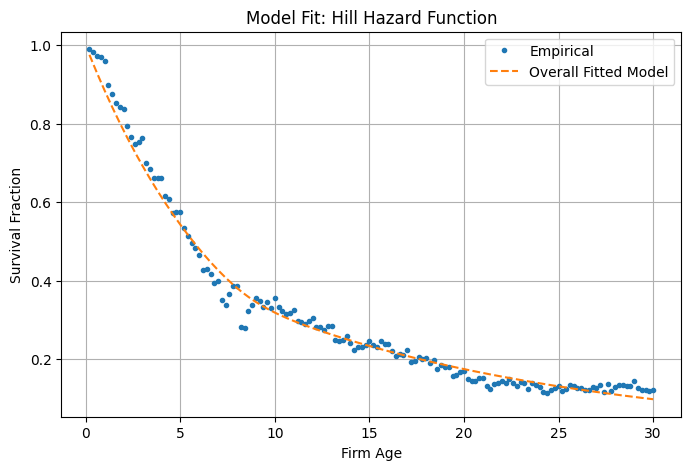

In [ ]:
# ---- Step 1: Define the Hill-type hazard function ----

def hill_hazard(a, mu_ub, mu_lb, K, m):
    return mu_ub - (mu_ub - mu_lb) * (a**m) / (a**m + K**m + 1e-10)  # Add epsilon to avoid div by 0

# ---- Step 2: Define survival function S(a) using quad integration ----

def hill_survival_function(a, mu_ub, mu_lb, K, m):
    result, _ = quad(lambda s: hill_hazard(s, mu_ub, mu_lb, K, m), 0, a)
    return np.exp(-result)

# ---- Step 3: Vectorized function to compute model survival over array of ages ----

def model_survival_curve_hill(ages, mu_ub, mu_lb, K, m):
    return np.array([hill_survival_function(a, mu_ub, mu_lb, K, m) for a in ages])

# ---- Step 4: Objective function to minimize squared error between model and empirical ----

def objective_hill(params, ages, observed_survival):
    mu_ub, mu_lb, K, m = params
    if mu_ub < mu_lb or mu_ub < 0 or mu_lb < 0:
        return np.inf
    predicted = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    return np.sum((predicted - observed_survival)**2)

# ---- Step 5: Fit parameters ----

def fit_survival_model(ages, survival_fractions, initial_guess=[0.1, 0.05, 5, 10]):
    '''
    Returns the params of the Hill function model giving the least squares error

    Inputs:
    ages = firm age bins
    survival_fractions = survival fraction of firms in each age bin
    initial_guess = initial guess for params [mu_ub, mu_lb, K, m]

    ''' 
    bounds = [(0.01, 0.3), (1e-10, 0.3), (0.1, 20), (0.5, 30)]
    result = minimize(objective_hill, initial_guess, args=(ages, survival_fractions), bounds=bounds)
    return result

# ---- Step 6: Example usage with your data ----

# Create age bins (e.g., every 2 years)
bins = np.arange(0, df_analysis['age'].max() + 1, 0.2)
df_analysis['age_bin'] = pd.cut(df_analysis['age'], bins)


# Compute survival fraction per bin
surv_frac = df_analysis.groupby('age_bin', observed=True)['status'].mean().reset_index()
surv_frac = surv_frac.loc[~(surv_frac == 0).any(axis=1)]
survival_fractions = np.array(surv_frac['status'])
ages = surv_frac['age_bin'].apply(lambda x: x.right)

result = fit_survival_model(ages, survival_fractions, [0.2, 0.05, 5, 10])
best_params = result.x
overall_predicted_curve = model_survival_curve_hill(ages, *best_params)
print(best_params)

# ---- Plot ----
plt.figure(figsize=(8, 5))
plt.plot(ages, survival_fractions, 'o', markersize = 3, label="Empirical")
plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
plt.xlabel("Firm Age")
plt.ylabel("Survival Fraction")
plt.title("Model Fit: Hill Hazard Function")
plt.grid(True)
plt.legend()
plt.show()

[ 0.10698779  0.07005365 12.27789093  5.293434  ]


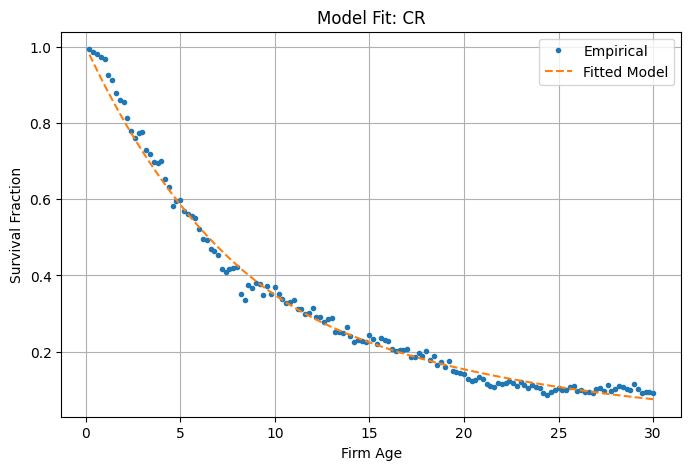

In [6]:
survival_frac, ages = obtain_survival_fractions(df_analysis, 'Region', 'CR')

result = fit_survival_model(ages, survival_frac, [0.2, 0.05, 5, 5])
best_params = result.x
predicted_curve = model_survival_curve_hill(ages, *best_params)
print(best_params)

# Plot model against empirical
plt.figure(figsize=(8, 5))
plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
plt.plot(ages, predicted_curve, '--', label="Fitted Model")
plt.xlabel("Firm Age")
plt.ylabel("Survival Fraction")
plt.title(f"Model Fit: {'CR'}")
plt.grid(True)
plt.legend()
plt.show()

[0.13574072 0.01468041 8.98682965 6.98900489]


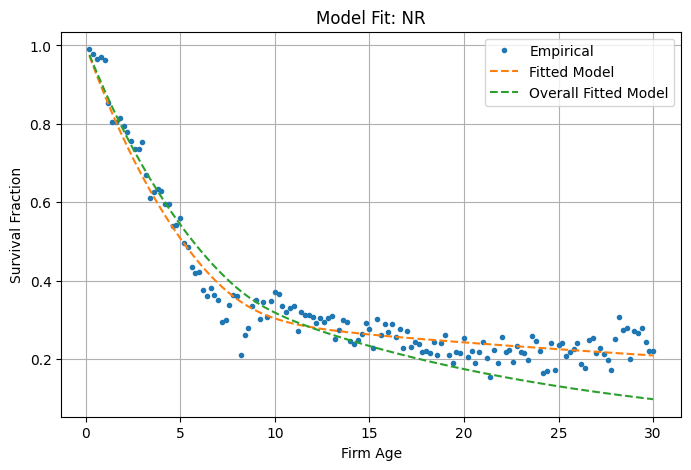

[1.37972743e-01 2.33438680e-02 8.71076705e+00 3.00000000e+01]


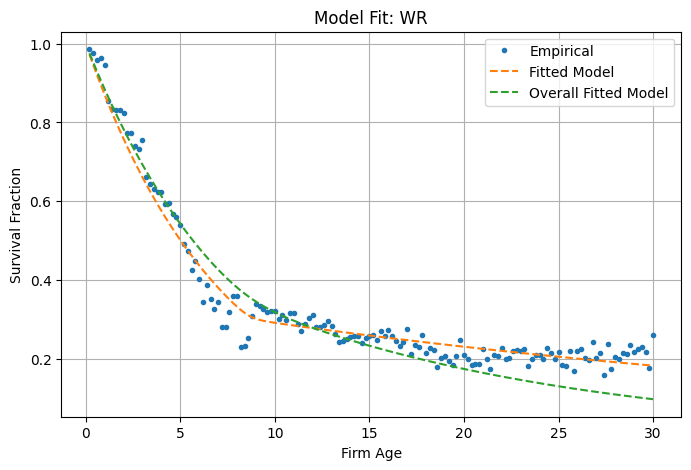

[ 0.10726218  0.07506705 10.92101112  7.17306074]


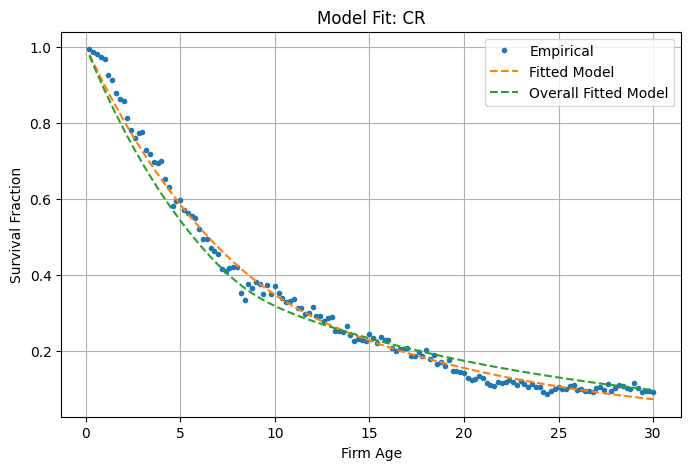

[0.14417407 0.02666818 9.64267843 7.01971434]


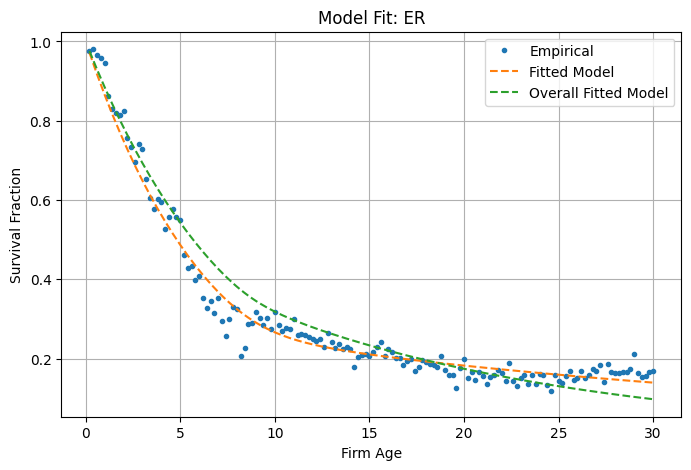

[ 0.15007426  0.03723088  8.223247   30.        ]


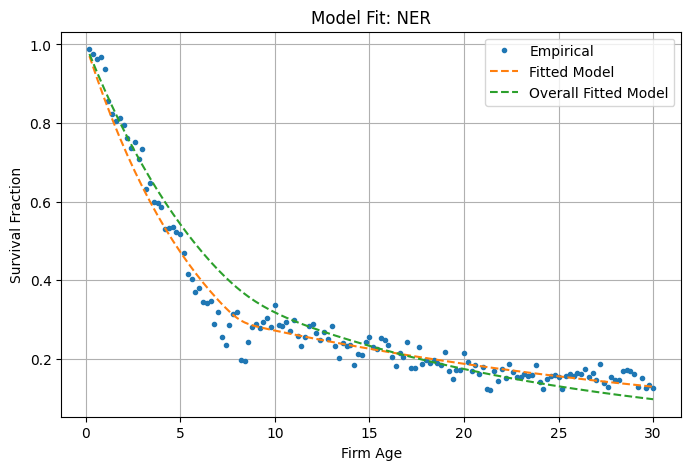

In [7]:
region_list = ['NR','WR','CR','ER','NER']

for region in region_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Region', region)
    result = fit_survival_model(ages, survival_frac, [0.2, 0.05, 8, 7])
    best_params = result.x
    predicted_curve = model_survival_curve_hill(ages, *best_params)
    print(best_params)

    # Plot model against empirical
    plt.figure(figsize=(8, 5))
    plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
    plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
    plt.xlabel("Firm Age")
    plt.ylabel("Survival Fraction")
    plt.title(f"Model Fit: {region}")
    plt.grid(True)
    plt.legend()
    plt.show()

[ 0.1355745   0.0611954   9.91861977 28.35679992]


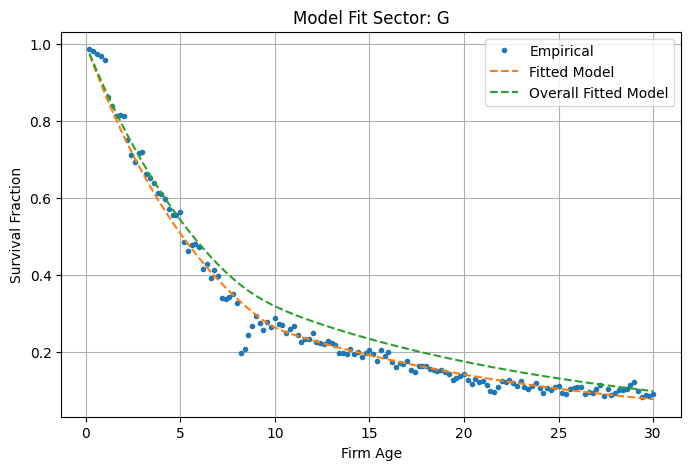

[ 0.10994361  0.05839617 10.35596655 13.55507506]


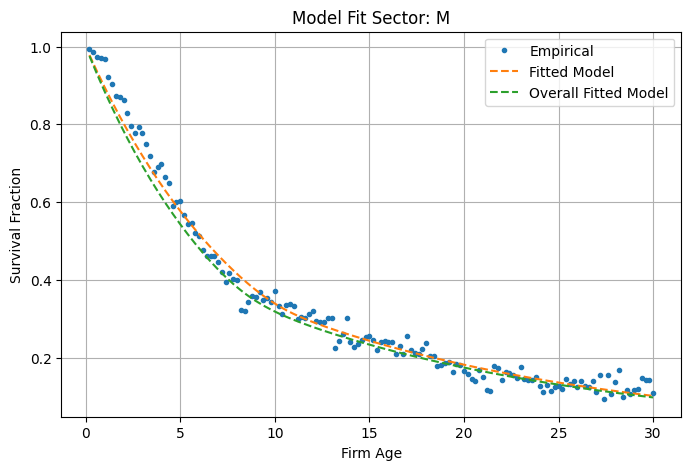

[0.14252258 0.02122713 8.82712325 4.98411213]


C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


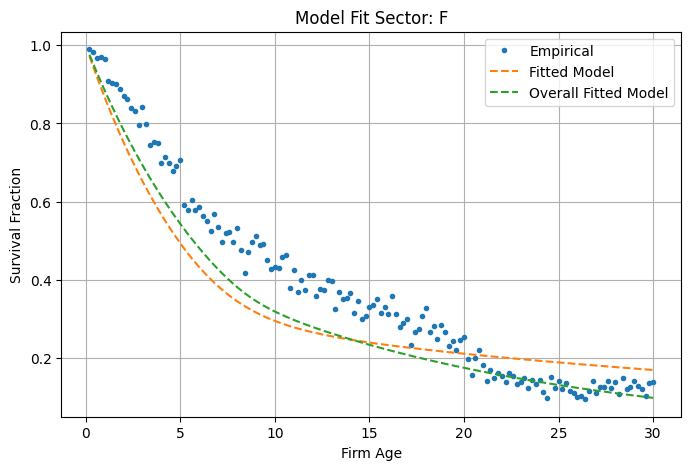

[ 0.13237387  0.05570557  9.59637041 10.65383709]


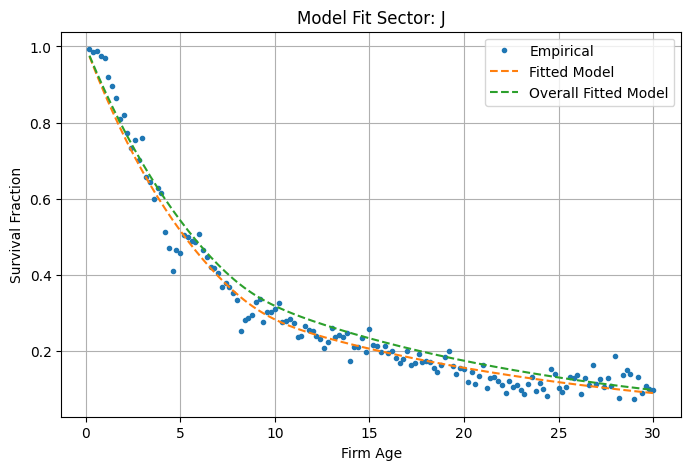

[7.23784135e-02 6.42361075e-03 1.74455001e+01 7.90703337e+00]


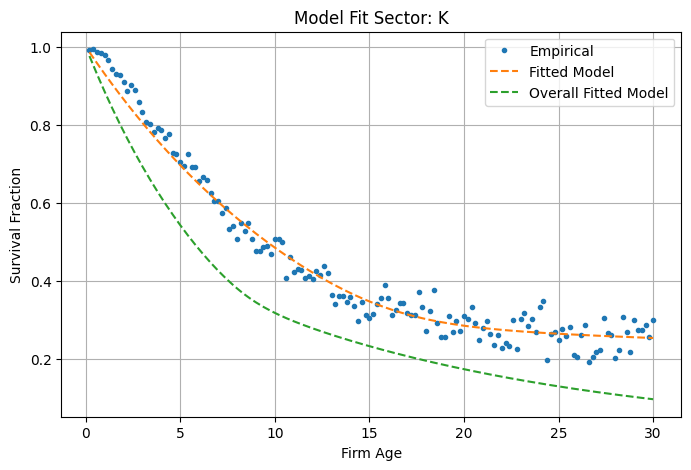

[ 0.10114905  0.04829989  8.60656092 30.        ]


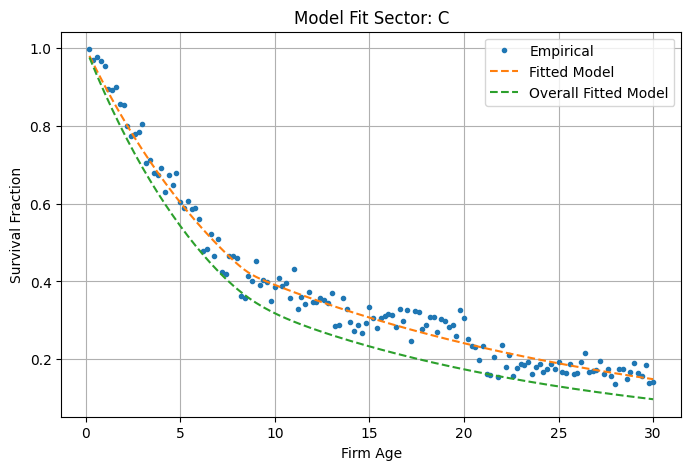

In [19]:
sector_list = ['G', 'M', 'F', 'J', 'K', 'C']

for sector in sector_list:
    survival_frac, ages = obtain_survival_fractions(df_analysis, 'Sector', sector)
    result = fit_survival_model(ages, survival_frac, [0.2, 0.03, 9, 5])
    best_params = result.x
    predicted_curve = model_survival_curve_hill(ages, *best_params)
    print(best_params)

    # Plot model against empirical
    plt.figure(figsize=(8, 5))
    plt.plot(ages, survival_frac, 'o', markersize = 3, label="Empirical")
    plt.plot(ages, predicted_curve, '--', label="Fitted Model")
    plt.plot(ages, overall_predicted_curve, '--', label="Overall Fitted Model")
    plt.xlabel("Firm Age")
    plt.ylabel("Survival Fraction")
    plt.title(f"Model Fit Sector: {sector}")
    plt.grid(True)
    plt.legend()
    plt.show()

In [15]:
# Negative log-likelihood for binomial MLE
def neg_log_likelihood_hill(params, ages, survivors, totals):
    mu_ub, mu_lb, K, m = params
    if mu_lb < 0 or mu_ub < mu_lb or K <= 0 or m <= 0:
        return np.inf

    S_vals = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)
    S_vals = np.clip(S_vals, 1e-12, 1 - 1e-12)  # avoid log(0)

    deaths = totals - survivors
    logL = np.sum(survivors * np.log(S_vals) + deaths * np.log(1 - S_vals))
    return -logL  # minimize negative log-likelihood

# Fit function
def fit_hill_model_mle(ages, survivors, totals, initial_guess=[0.3, 0.01, 5.0, 2.0]):
    '''
    ages = vector of ages
    survivors = number of survivors in age bin
    totals = total number of firms in age bin
    initial_guess = [mu_ub, mu_lb, K, m]

    returns best params according to MLE
    
    '''
    bounds = [(0.01, 0.3), (1e-10, 0.2), (0.01, 30), (0.5, 20)]
    result = minimize(neg_log_likelihood_hill, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result.x


ll for NR: -59042.13395302379
params mu_ub, mu_lb, K, m are [0.13714179539633112, 0.022936288657930633, 8.340043036153924, 20.0]


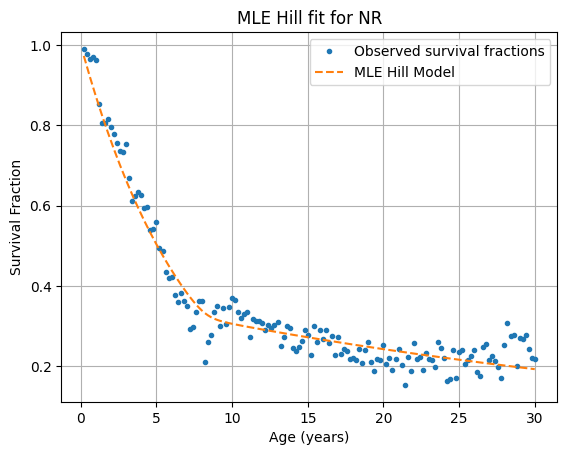

ll for WR: -95468.22147665564
params mu_ub, mu_lb, K, m are [0.13866488202654664, 0.024364824491223864, 8.617459288068819, 20.0]


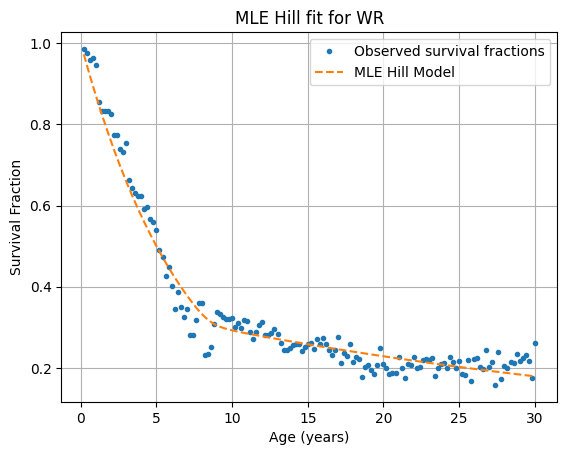

ll for CR: -419940.2967447231
params mu_ub, mu_lb, K, m are [0.10403999980908983, 0.05057266208768737, 17.3218925194293, 5.549232513922519]


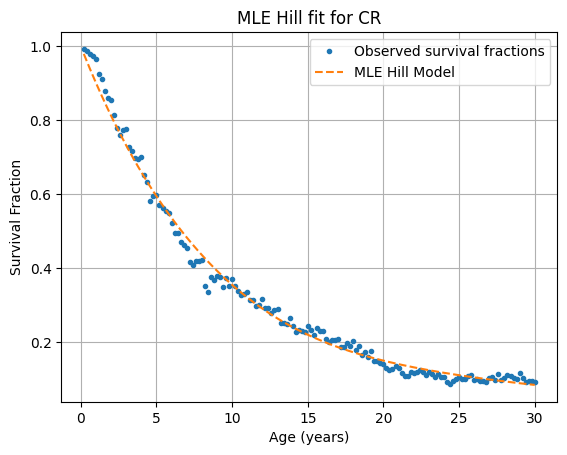

ll for ER: -71353.71988095024
params mu_ub, mu_lb, K, m are [0.14658203631116415, 0.036196309195325266, 8.74173787882183, 20.0]


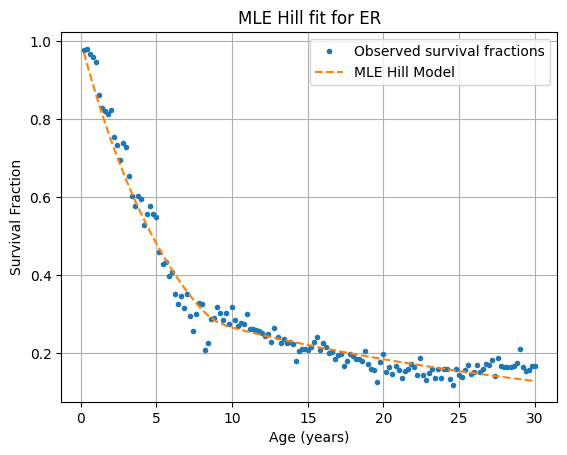

ll for NER: -81367.46536082264
params mu_ub, mu_lb, K, m are [0.1519924726388226, 0.03555655097006877, 8.234535576476992, 20.0]


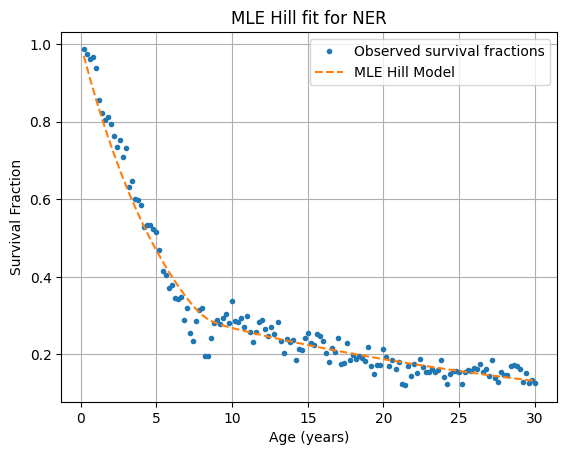

In [13]:
region_ll_hill = []
for fil in region_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals)

    # Plot fit
    fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

    print(f'll for {fil}: {-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals)}')
    region_ll_hill.append(neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals))

    print(f'params mu_ub, mu_lb, K, m are {[float(x) for x in [mu_ub, mu_lb, K, m]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
    plt.title(f'MLE Hill fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()


ll for G: -198296.3562945738
params mu_ub, mu_lb, K, m are [0.13739717214343217, 0.05915636023781002, 9.871137705585735, 20.0]


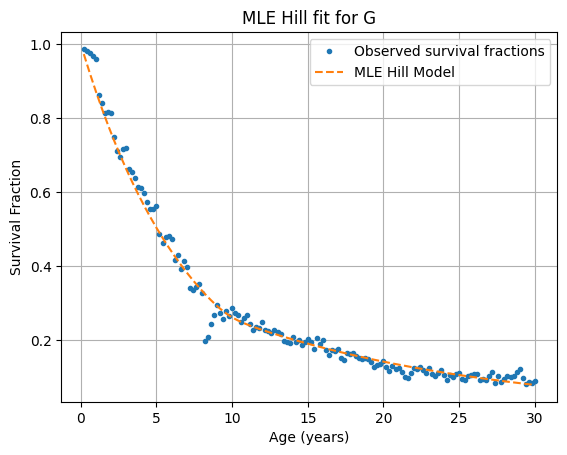

ll for M: -106892.48755661881
params mu_ub, mu_lb, K, m are [0.1085303658163346, 0.06037746487304393, 10.332021726469355, 20.0]


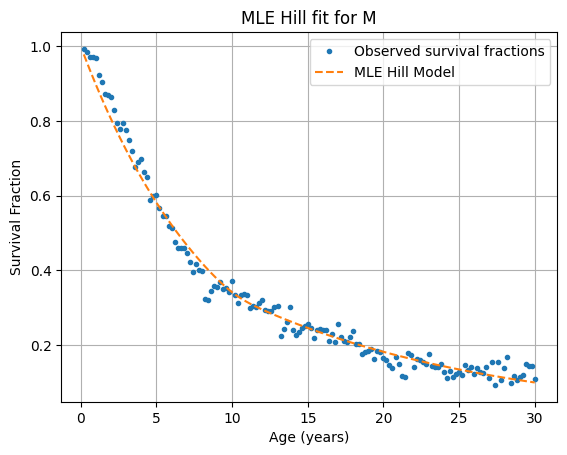

ll for F: -47774.5600189914
params mu_ub, mu_lb, K, m are [0.08001362695876077, 1e-10, 26.83046617514036, 20.0]


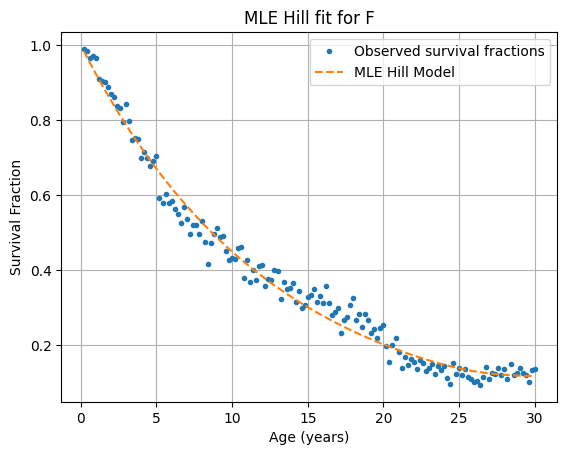

ll for J: -56998.884859161575
params mu_ub, mu_lb, K, m are [0.1304730164556451, 0.02777008603059709, 13.074444848569547, 3.70087329058587]


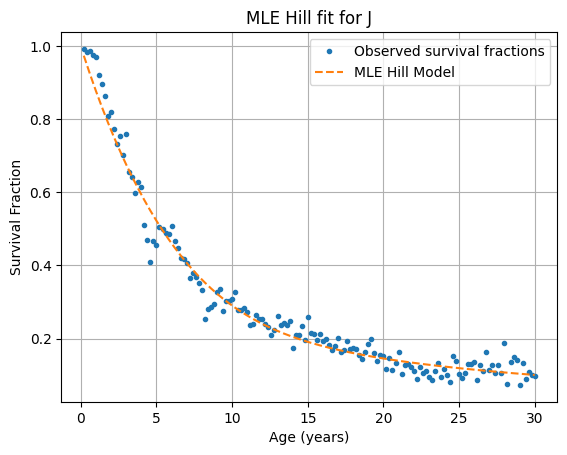

ll for K: -56225.88857517662
params mu_ub, mu_lb, K, m are [0.0723785797, 0.0064302035, 17.4446268, 7.90856056]


C:\Users\chong\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_numdiff.py:686: RuntimeWarning: invalid value encountered in subtract
  df = [f_eval - f0 for f_eval in f_evals]


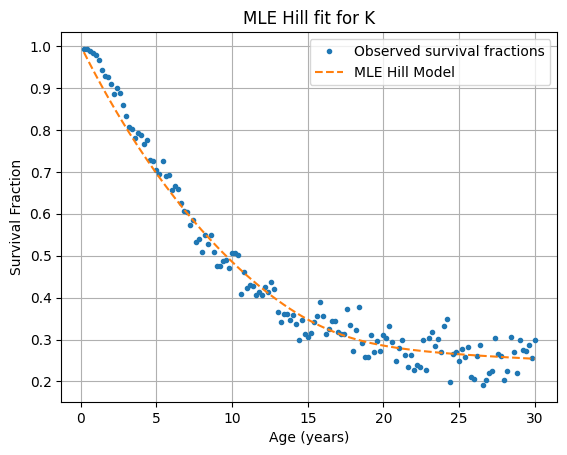

ll for C: -39547.70068996204
params mu_ub, mu_lb, K, m are [0.10011316057746077, 0.04583457474867924, 9.125902641336852, 5.525421260574259]


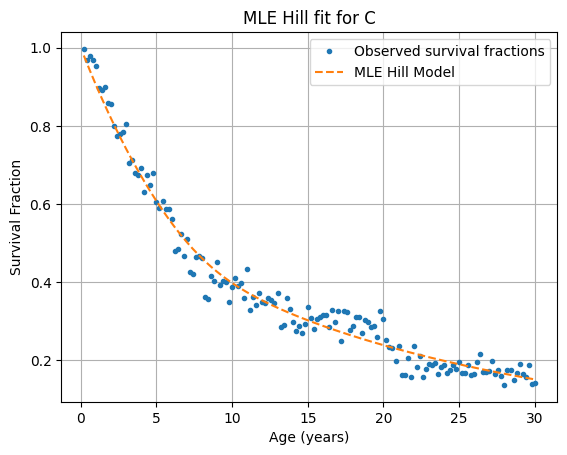

In [16]:
sector_ll_hill = []
for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    mu_ub, mu_lb, K, m = fit_hill_model_mle(ages, survivors, totals, initial_guess=[7.23785797e-02, 6.43020350e-03, 1.74446268e+01, 7.90856056e+00])

    # Plot fit
    fitted_S = model_survival_curve_hill(ages, mu_ub, mu_lb, K, m)

    print(f'll for {fil}: {-neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals)}')
    sector_ll_hill.append(neg_log_likelihood_hill([mu_ub, mu_lb, K, m], ages, survivors, totals))

    print(f'params mu_ub, mu_lb, K, m are {[float(x) for x in [mu_ub, mu_lb, K, m]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE Hill Model', linestyle='--')
    plt.title(f'MLE Hill fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

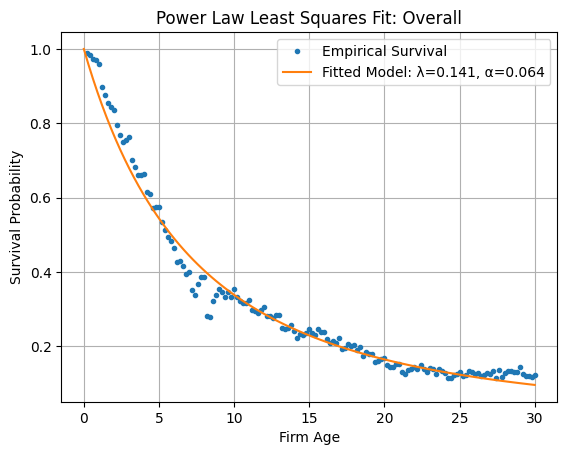

In [11]:
# ---- Closed-form survival function ----
def power_survival_function(t, lam, alpha):
    return (1 + alpha * t) ** (-lam / alpha)

# ---- Predict survival over a list of ages ----
def model_survival_curve_power(ages, lam, alpha):
    return np.array([power_survival_function(t, lam, alpha) for t in ages])

# ---- Least squares objective function ----
def objective_power(params, ages, observed_survival):
    lam, alpha = params
    if lam <= 0 or alpha < 0:
        return np.inf  # invalid parameters
    predicted = model_survival_curve_power(ages, lam, alpha)
    return np.sum((predicted - observed_survival) ** 2)

# ---- Fit the model using least squares ----
def fit_power_model(ages, survival_fractions):
    initial_guess = [0.2, 0.1]  # lambda, alpha
    bounds = [(1e-5, None), (0, None)]
    result = minimize(objective_power, initial_guess, args=(ages, survival_fractions), bounds=bounds)
    return result

# - ages: list or array of firm ages
# - survival_fractions: corresponding empirical survival fractions

# Create age bins (e.g., every 2 years)
bins = np.arange(0, df_analysis['age'].max() + 1, 0.2)
df_analysis['age_bin'] = pd.cut(df_analysis['age'], bins)
# Compute survival fraction per bin
survival_fractions, ages = obtain_survival_fractions(df_analysis)

result = fit_power_model(ages, survival_fractions)
lam_fit, alpha_fit = result.x

# Plot result
ages_sorted = np.linspace(0, max(ages), 100)
fitted_survival = model_survival_curve_power(ages_sorted, lam_fit, alpha_fit)

plt.plot(ages, survival_fractions, 'o', markersize=3, label='Empirical Survival')
plt.plot(ages_sorted, fitted_survival, label='Fitted Model: λ=%.3f, α=%.3f' % (lam_fit, alpha_fit))
plt.xlabel("Firm Age")
plt.ylabel("Survival Probability")
plt.title("Power Law Least Squares Fit: Overall")
plt.grid(True)
plt.legend()
plt.show()


In [19]:
def neg_log_likelihood_power(params, ages, survivors, totals):
    lam, alpha = params
    if lam <= 0 or alpha <= 0:
        return np.inf

    S = power_survival_function(ages, lam, alpha)
    S = np.clip(S, 1e-12, 1 - 1e-12)  # avoid log(0)
    deaths = totals - survivors

    logL = np.sum(survivors * np.log(S) + deaths * np.log(1 - S))
    return -logL

def fit_power_model_mle(ages, survivors, totals):
    initial_guess = [0.1, 0.1]  # lam, alpha
    bounds = [(1e-6, 1), (1e-6, 1)]
    result = minimize(neg_log_likelihood_power, initial_guess,
                      args=(ages, survivors, totals),
                      bounds=bounds)
    return result.x

ll for NR: -59567.6477521164
params lam, alpha are [0.1886195039277679, 0.18894739950045433]


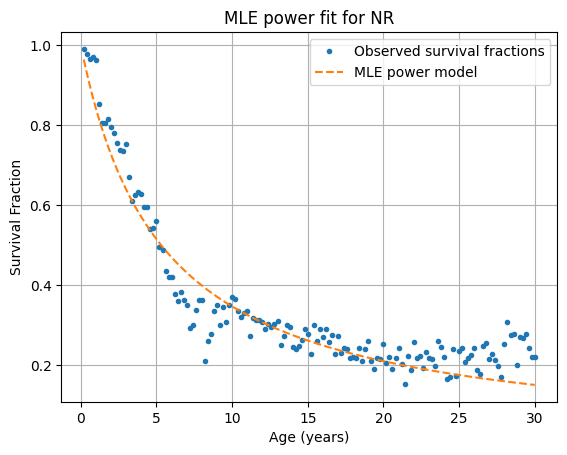

ll for WR: -96324.21879628443
params lam, alpha are [0.1889317727879867, 0.1784994064944407]


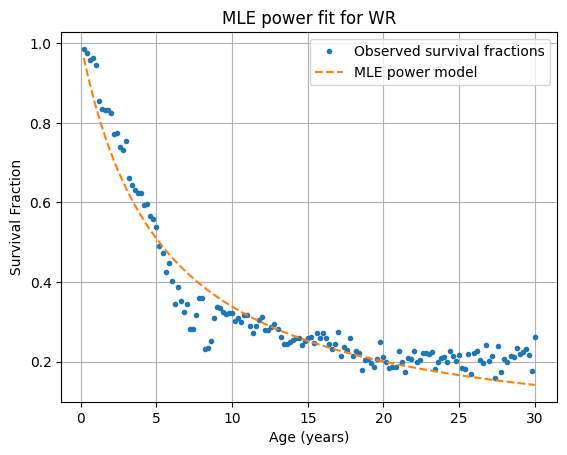

ll for CR: -420253.2008882553
params lam, alpha are [0.11069175500249837, 0.018335267155011367]


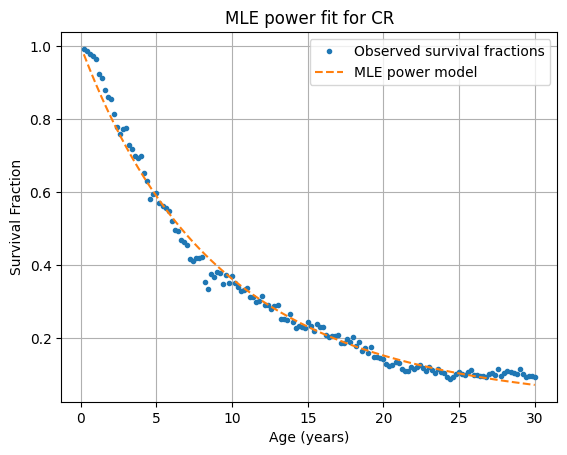

ll for ER: -71816.8062091888
params lam, alpha are [0.19149996695221363, 0.14322742737330993]


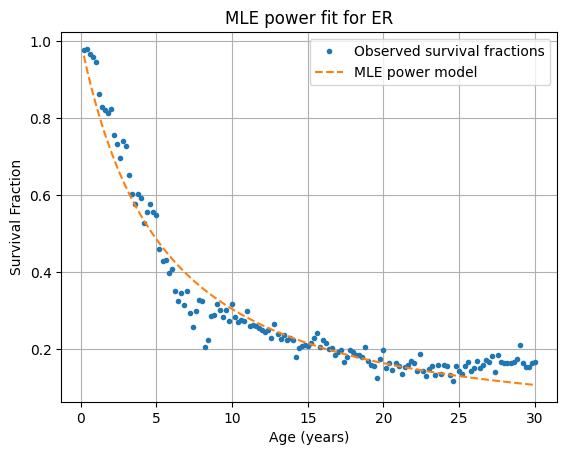

ll for NER: -82060.31237407553
params lam, alpha are [0.1989416274219653, 0.15602637405446237]


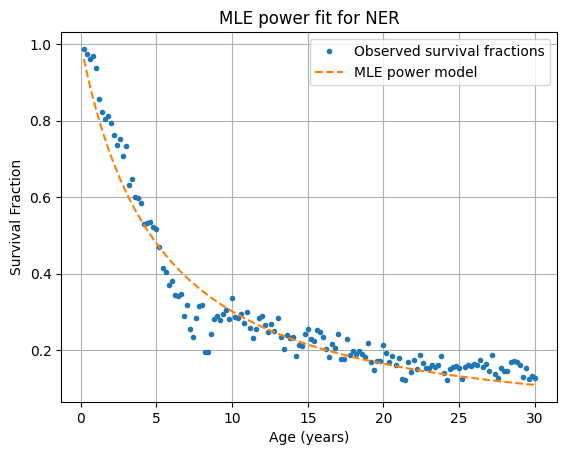

In [37]:
region_ll_power = []
for fil in region_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Region', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Region', fil)

    lam, alpha = fit_power_model_mle(ages, survivors, totals)

    # Plot fit
    fitted_S = model_survival_curve_power(ages, lam, alpha)

    print(f'll for {fil}: {-neg_log_likelihood_power([lam, alpha], ages, survivors, totals)}')
    region_ll_power.append(neg_log_likelihood_power([lam, alpha], ages, survivors, totals))

    print(f'params lam, alpha are {[float(x) for x in [lam, alpha]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE power model', linestyle='--')
    plt.title(f'MLE power fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

ll for G: -198944.67602002577
params lam, alpha are [0.15939620292528545, 0.06554740821430066]


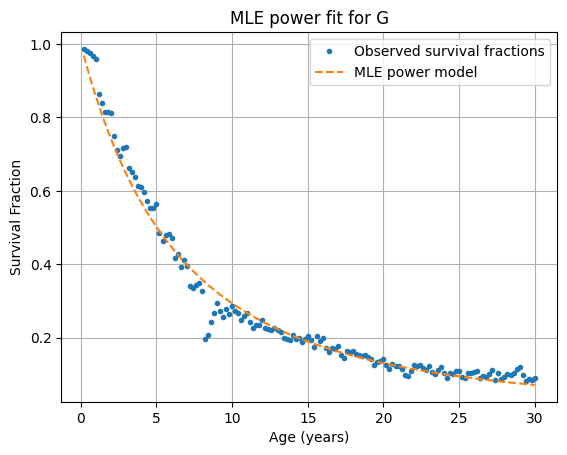

ll for M: -107109.28350819302
params lam, alpha are [0.11731541174879027, 0.034411617250405084]


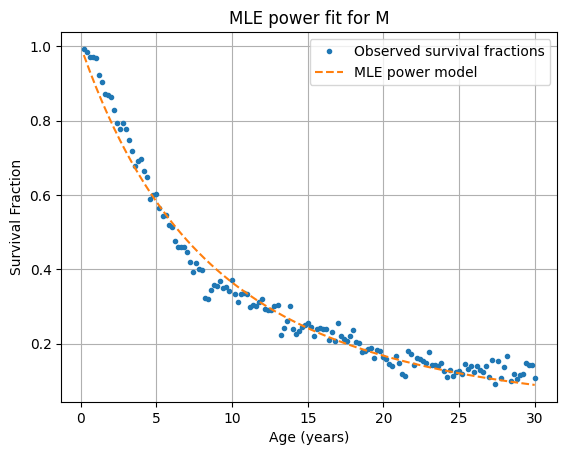

ll for F: -47789.79890249316
params lam, alpha are [0.08176472979107174, 0.003935373274942269]


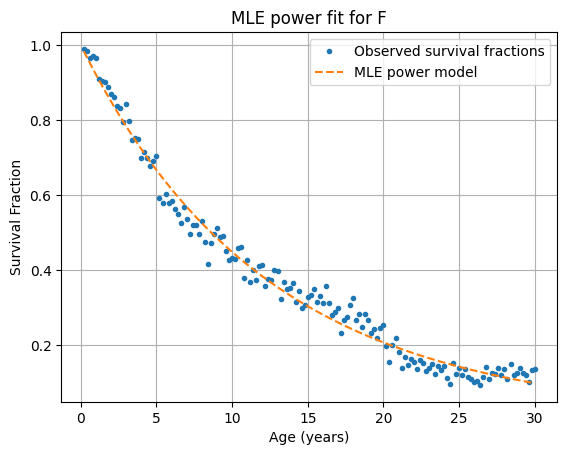

ll for J: -57151.028483457565
params lam, alpha are [0.14493123831512508, 0.05110384606085803]


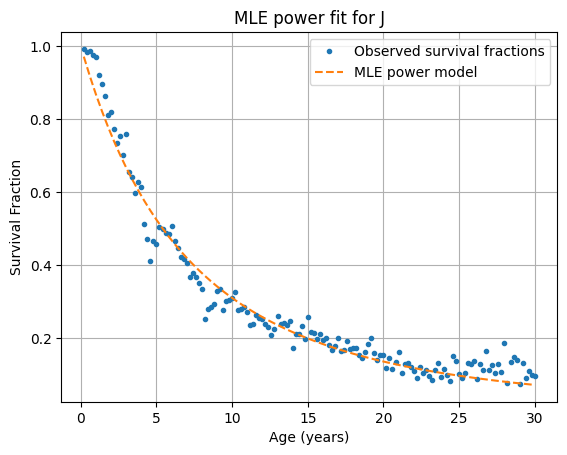

ll for K: -56413.996435860274
params lam, alpha are [0.07428516022902562, 0.0205752635062873]


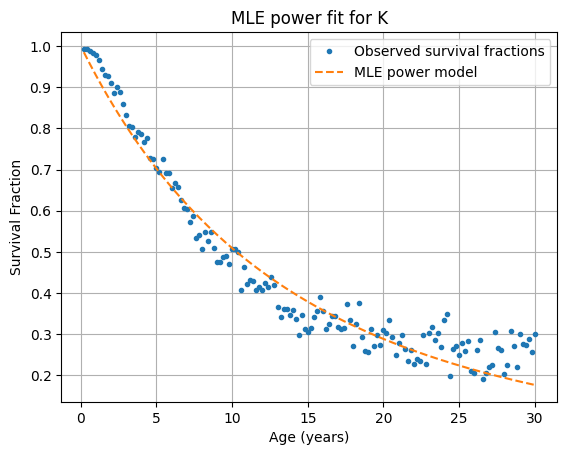

ll for C: -39594.27698304424
params lam, alpha are [0.11483004186551288, 0.06612012042977906]


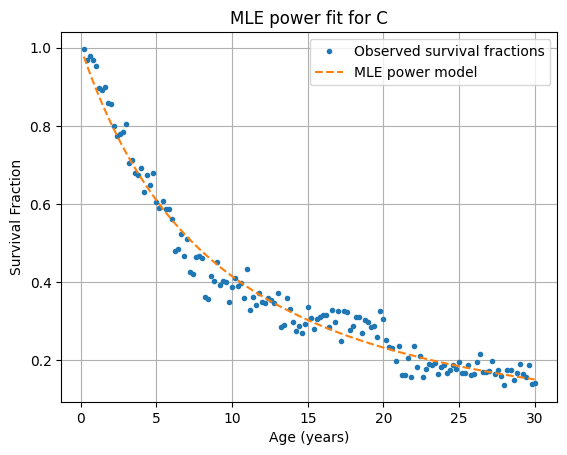

In [36]:
sector_ll_power = []

for fil in sector_list:

    sf, ages = obtain_survival_fractions(df_analysis, 'Sector', fil)

    totals, survivors = obtain_total_alive_count(df_analysis, 'Sector', fil)

    lam, alpha = fit_power_model_mle(ages, survivors, totals)

    # Plot fit
    fitted_S = model_survival_curve_power(ages, lam, alpha)

    print(f'll for {fil}: {-neg_log_likelihood_power([lam, alpha], ages, survivors, totals)}')
    sector_ll_power.append(neg_log_likelihood_power([lam, alpha], ages, survivors, totals))

    print(f'params lam, alpha are {[float(x) for x in [lam, alpha]]}')

    plt.plot(ages, sf, 'o', markersize = 3, label='Observed survival fractions')
    plt.plot(ages, fitted_S, label='MLE power model', linestyle='--')
    plt.title(f'MLE power fit for {fil}')
    plt.xlabel('Age (years)')
    plt.ylabel('Survival Fraction')
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
def compute_aic_bic(neg_logL, k, n):
    '''
    k = number of params
    n = number of observations
    '''

    aic = 2 * k + 2 * neg_logL
    bic = k * np.log(n) + 2 * neg_logL
    return aic, bic

In [41]:
region_aic_hill, region_bic_hill = compute_aic_bic(np.array(region_ll_hill), 4, len(ages))
region_aic_power, region_bic_power = compute_aic_bic(np.array(region_ll_power), 2, len(ages))

region_df = pd.DataFrame({
    'Region': region_list,
    'AIC_Hill': region_aic_hill,
    'AIC_Power': region_aic_power,
    'BIC_Hill': region_bic_hill,
    'BIC_Power': region_bic_power
})

region_df.head()

,Region,AIC_Hill,AIC_Power,BIC_Hill,BIC_Power
0,NR,118092.267906,119139.295504,118104.310447,119145.316775
1,WR,190944.442900,192652.437593,190956.485441,192658.458863
2,CR,839888.576485,840510.401777,839900.619026,840516.423047
3,ER,142715.439762,143637.612418,142727.482303,143643.633689
4,NER,162742.930719,164124.624748,162754.973260,164130.646019


In [44]:
sector_aic_hill, sector_bic_hill = compute_aic_bic(np.array(sector_ll_hill), 4, len(ages))
sector_aic_power, sector_bic_power = compute_aic_bic(np.array(sector_ll_power), 2, len(ages))

sector_df = pd.DataFrame({
    'Sector': sector_list,
    'AIC_Hill': sector_aic_hill,
    'AIC_Power': sector_aic_power,
    'BIC_Hill': sector_bic_hill,
    'BIC_Power': sector_bic_power
})

sector_df.head(6)

,Sector,AIC_Hill,AIC_Power,BIC_Hill,BIC_Power
0,G,396804.160509,397893.352040,396816.203050,397899.373311
1,M,213792.975113,214222.567016,213805.017654,214228.588287
2,F,95557.264603,95583.597805,95569.307144,95589.619076
3,J,114005.769381,114306.056967,114017.811922,114312.078238
4,K,112459.777150,112831.992872,112471.819692,112838.014142
5,C,79103.401380,79192.553966,79115.443921,79198.575237
